# Plot Curvature of a Variety of *Image* Models

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="2"
%load_ext autoreload
from fast_curvature import *


In [2]:
%autoreload 2
from fast_curvature import *

In [2]:
# pretrained
name = 'resnet50'
model = models.__dict__[name](pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
# robust
name = 'resnet50'
model = models.__dict__[name](pretrained=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load('imagenet_l2_3_0.pt')

from collections import OrderedDict
new_state_dict1 = OrderedDict()
i= 0
for k, v in checkpoint['model'].items():
    if i == 0 or i == 1:
        i = i + 1
        continue
    if i>321:
        i = i + 1
        continue
    name =  k[13:] # remove `module.`
    new_state_dict1[name] = v
    i = i + 1

model.load_state_dict(new_state_dict1)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [75]:
#vonenet
import sys
sys.path.append('../../vonenet')
import vonenet

v1_model = vonenet.get_model(model_arch='resnet50_ns', pretrained=True).module
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = v1_model.to(device)
model.eval()


model_blocks = [model.vone_block,
                model.model.layer1,
                model.model.layer2,
                model.model.layer3,
                model.model.layer4,
                model.model.avgpool]

Neuronal distributions gabor parameters


/data/vision/billf/scratch/annekh/PredStraightening/Henaff_straightening/../../vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Model:  VOneResnet50


In [3]:
model_blocks = [model.layer1,
                model.layer2,
                model.layer3,
                model.layer4,
                model.avgpool]

# hooks, activations = get_intermediate_activations(model_blocks)

In [4]:
vid = load_all_henaff_videos('./stimuli/gamma1/',img_size=256)
natural = torch.from_numpy(vid['natural'],).permute((0,1,4,3,2)).float().contiguous()
contrast = torch.from_numpy(vid['contrast']).permute((0,1,4,3,2)).float().contiguous()
artificial = torch.from_numpy(vid['artificial']).permute((0,1,4,3,2)).float().contiguous()
videos = [natural.to(device),contrast.to(device), artificial.to(device)]
all_videos = vid

natural
contrast
artificial


In [8]:
curvs_natural = torch.mean(get_intermediate_curv(model, model_blocks,videos[0]),0)
curvs_contrast = torch.mean(get_intermediate_curv(model, model_blocks,videos[1]),0)
curvs_artificial = torch.mean(get_intermediate_curv(model, model_blocks,videos[2]),0)

In [78]:
natural_plot = curvs_natural - curvs_natural[0].repeat(curvs_natural.size(0))
contrast_plot = curvs_contrast - curvs_contrast[0].repeat(curvs_contrast.size(0))
artificial_plot = curvs_artificial - curvs_artificial[0].repeat(curvs_artificial.size(0))

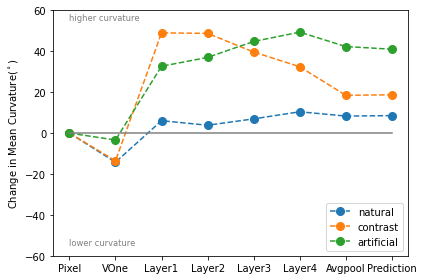

In [79]:
xlabels = ['Pixel', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Avgpool', 'Prediction']
xlabels = ['Pixel', 'VOne','Layer1', 'Layer2', 'Layer3', 'Layer4', 'Avgpool', 'Prediction']

plt.figure(figsize=(6,4))
plt.plot(xlabels, natural_plot, '--o',markersize=8,label='natural')
plt.plot(xlabels, contrast_plot, '--o',markersize=8,label='contrast')
plt.plot(xlabels, artificial_plot, '--o',markersize=8,label='artificial')

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-60, 60])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[0], -55,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[0], 55,'higher curvature', color='gray',fontsize='small')
plt.legend()
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
# name = 'resnet50_robust_l2_3_0'
name = 'vonenet'
plt.savefig(f'{name}_curve_change.png',dpi=300)

### Cross ViT Curvature [Baseline]

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
%load_ext autoreload
from fast_curvature import *

from timm.models import create_model
model = create_model('crossvit_18_dagger_408',pretrained = True)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = nn.DataParallel(model)
model = model.to(device)
model.eval()

DataParallel(
  (module): CrossViT(
    (patch_embed): ModuleList(
      (0): PatchEmbed(
        (proj): Sequential(
          (0): Conv2d(3, 56, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (1): ReLU(inplace=True)
          (2): Conv2d(56, 112, kernel_size=(3, 3), stride=(3, 3))
          (3): ReLU(inplace=True)
          (4): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): PatchEmbed(
        (proj): Sequential(
          (0): Conv2d(3, 112, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (1): ReLU(inplace=True)
          (2): Conv2d(112, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(224, 448, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
      )
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): MultiScaleBlock(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Blo

In [3]:
model_blocks = [model.module.blocks[0],model.module.blocks[1],model.module.blocks[2],model.module.norm, model.module.head]
# device= 'cpu'


In [4]:
vid = load_all_henaff_videos('./stimuli/gamma1/',img_size=256)
natural = torch.from_numpy(vid['natural'],).permute((0,1,4,3,2)).float().contiguous()
contrast = torch.from_numpy(vid['contrast']).permute((0,1,4,3,2)).float().contiguous()
artificial = torch.from_numpy(vid['artificial']).permute((0,1,4,3,2)).float().contiguous()
videos = [natural.to(device),contrast.to(device), artificial.to(device)]
all_videos = vid

natural
contrast
artificial


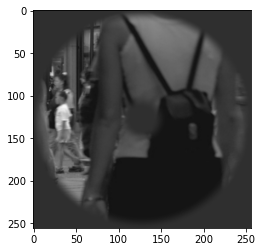

In [5]:
%autoreload 2
from fast_curvature import *
plt.imshow(natural[5,9,:,:,:].permute((2,1,0)).detach().cpu().numpy(),vmin=0,vmax=1)

In [5]:
path = 0
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0],vit=True,path=path,)
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1],vit=True,path=path)
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2],vit=True,path=path)


In [6]:
mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

std_natural = curvs_natural.std(0)/11**0.5
std_contrast = curvs_contrast.std(0)/11**0.5
std_artificial = curvs_artificial.std(0)/11**0.5

In [10]:
model

DataParallel(
  (module): CrossViT(
    (patch_embed): ModuleList(
      (0): PatchEmbed(
        (proj): Sequential(
          (0): Conv2d(3, 56, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (1): ReLU(inplace=True)
          (2): Conv2d(56, 112, kernel_size=(3, 3), stride=(3, 3))
          (3): ReLU(inplace=True)
          (4): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): PatchEmbed(
        (proj): Sequential(
          (0): Conv2d(3, 112, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (1): ReLU(inplace=True)
          (2): Conv2d(112, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(224, 448, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
      )
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): MultiScaleBlock(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Blo

In [7]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

In [9]:
mean_natural

tensor([84.7424, 74.1926, 73.1104, 72.3645,  0.0000,  0.0000, 96.7199])

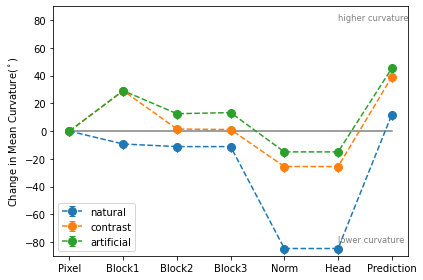

In [8]:
xlabels = ['Pixel', 'Block1', 'Block2', 'Block3','Norm','Head','Prediction']
output_dir = './vit_curves'
os.makedirs(output_dir,exist_ok=True)

plt.figure(figsize=(6,4))
plt.errorbar(xlabels, natural_plot, yerr=std_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=std_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=std_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-90, 90])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[-2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[-2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
# name = 'resnet50_robust_l2_3_0'
name = f'crossvit_baseline_august_path_{path}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
# plt.savefig(save_name,dpi=300)

## ViT Curvature

In [5]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
%load_ext autoreload
from fast_curvature import *

from timm.models import create_model
v = 4
vit_names = ['vit_tiny_patch16_224','vit_small_patch16_224','vit_base_patch32_224','vit_base_patch16_224']
model = create_model(vit_names[v],pretrained = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: Unknown model (vit_small_patch8_224_dino)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = nn.DataParallel(model)
model = model.to(device)
model.eval()

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop2): Dropout(p=0.0,

In [7]:
vid = load_all_henaff_videos('./stimuli/gamma1/',img_size=224)
natural = torch.from_numpy(vid['natural'],).permute((0,1,4,3,2)).float().contiguous()
contrast = torch.from_numpy(vid['contrast']).permute((0,1,4,3,2)).float().contiguous()
artificial = torch.from_numpy(vid['artificial']).permute((0,1,4,3,2)).float().contiguous()
videos = [natural.to(device),contrast.to(device), artificial.to(device)]
all_videos = vid

natural
contrast
artificial


In [8]:
model_blocks = [model.module.blocks[0],model.module.blocks[2],model.module.blocks[4],model.module.blocks[6],model.module.blocks[8],model.module.blocks[10]]


In [9]:
path = None
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0],vit=True,path=path,)
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1],vit=True,path=path)
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2],vit=True,path=path)


In [10]:
mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

std_natural = curvs_natural.std(0)/11**0.5
std_contrast = curvs_contrast.std(0)/11**0.5
std_artificial = curvs_artificial.std(0)/11**0.5

In [11]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

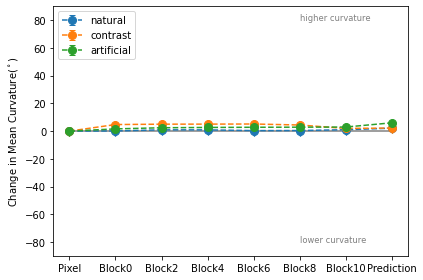

In [12]:
xlabels = ['Pixel', 'Block0', 'Block2', 'Block4','Block6','Block8','Block10','Prediction']
output_dir = './vit_september_curves'
os.makedirs(output_dir,exist_ok=True)

plt.figure(figsize=(6,4))
plt.errorbar(xlabels, natural_plot, yerr=std_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=std_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=std_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-90, 90])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[-3], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[-3], 80,'higher curvature', color='gray',fontsize='small')

plt.legend(loc='upper left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
# name = 'resnet50_robust_l2_3_0'
name = f'{vit_names[v]}_september'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)

## DINO

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
%load_ext autoreload
from fast_curvature import *

from timm.models import create_model
v = 1
vit_names = ['dino_vits16','dino_vits8']
model = torch.hub.load('facebookresearch/dino:main', vit_names[v])


Using cache found in /data/vision/billf/scratch/annekh/.cache/torch/hub/facebookresearch_dino_main
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth" to /data/vision/billf/scratch/annekh/.cache/torch/hub/checkpoints/dino_deitsmall8_pretrain.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = nn.DataParallel(model)
model = model.to(device)
model.eval()

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((384,), 

In [3]:
vid = load_all_henaff_videos('./stimuli/gamma1/',img_size=224)
natural = torch.from_numpy(vid['natural'],).permute((0,1,4,3,2)).float().contiguous()
contrast = torch.from_numpy(vid['contrast']).permute((0,1,4,3,2)).float().contiguous()
artificial = torch.from_numpy(vid['artificial']).permute((0,1,4,3,2)).float().contiguous()
videos = [natural.to(device),contrast.to(device), artificial.to(device)]
all_videos = vid

natural
contrast
artificial


In [4]:
model_blocks = [model.module.blocks[0],model.module.blocks[2],model.module.blocks[4],model.module.blocks[6],model.module.blocks[8],model.module.blocks[10]]


In [5]:
path = None
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0],vit=True,path=path,)
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1],vit=True,path=path)
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2],vit=True,path=path)

In [6]:
mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

std_natural = curvs_natural.std(0)/11**0.5
std_contrast = curvs_contrast.std(0)/11**0.5
std_artificial = curvs_artificial.std(0)/11**0.5

In [7]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

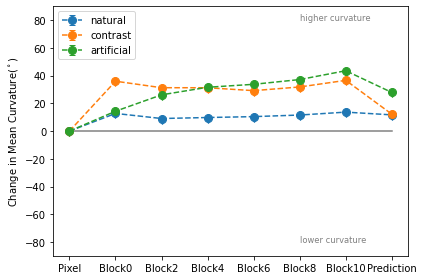

In [8]:
xlabels = ['Pixel', 'Block0', 'Block2', 'Block4','Block6','Block8','Block10','Prediction']
output_dir = './vit_september_curves'
os.makedirs(output_dir,exist_ok=True)

plt.figure(figsize=(6,4))
plt.errorbar(xlabels, natural_plot, yerr=std_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=std_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=std_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-90, 90])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[-3], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[-3], 80,'higher curvature', color='gray',fontsize='small')

plt.legend(loc='upper left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
# name = 'resnet50_robust_l2_3_0'
name = f'{vit_names[v]}_september'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)